<a href="https://colab.research.google.com/github/makaishi2/dl-math-v2-doc/blob/main/notebooks/7_regression_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# PDF印刷用
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-01-'

def create_pdf():
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

### 7章　線形回帰　リファクタリング版

### 環境準備

#### ライブラリ導入

In [25]:
# ライブラリ導入
!pip install japanize-matplotlib -q

#### ライブラリインポート

In [26]:
# ライブラリインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
from sklearn.datasets import fetch_openml
import warnings

#### 環境設定

In [27]:
# 環境設定
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')


### データ読み込み

#### 読み込み関数定義

In [28]:
# 読み込み関数定義

def load_california_housing():
    """California Housing データセットを取得し DataFrame を返す"""
    try:
        data = fetch_openml(name="california", version=2, as_frame=True)
        features = data.data
        target = data.target.astype(float)
        df = pd.concat([features, target.rename("MedianHouseValue")], axis=1)

        print("データの読み込みが完了しました。")
        print(f"サンプル数: {df.shape[0]:,} 件, 特徴量数: {df.shape[1]-1} 個")
        return df
    except Exception as e:
        print("データ読み込みエラー:", e)
        return None


#### 読み込み

In [29]:
# 読み込み
df = load_california_housing()

データの読み込みが完了しました。
サンプル数: 20,640 件, 特徴量数: 8 個


#### 内容確認

In [30]:
# 内容確認

# 先頭5行表示
display(df.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.325,41.000,6.984,1.024,322.000,2.556,37.880,-122.230,1.709
1,8.301,21.000,6.238,0.972,2401.000,2.110,37.860,-122.220,1.523
2,7.257,52.000,8.288,1.073,496.000,2.802,37.850,-122.240,1.509
3,5.643,52.000,5.817,1.073,558.000,2.548,37.850,-122.250,1.485
4,3.846,52.000,6.282,1.081,565.000,2.181,37.850,-122.250,1.487


### データ加工

#### 特徴量MedIncの抽出

In [31]:
# 特徴量MedIncの抽出
x_data = df[['MedInc']].values

#### ダミー変数（定数項）追加

In [32]:
# ダミー変数（定数項）追加
x = np.insert(x_data, 0, 1.0, axis=1)

#### 目的変数ytの設定

In [33]:
# 目的変数ytの設定
yt = df['MedianHouseValue'].values

#### 加工結果確認

In [34]:
# 加工結果確認

print("xとytのshape")
print(f"x.shape: {x.shape}, yt.shape: {yt.shape}")

print('xの先頭5行')
print(x[:5])

print('ytの先頭5要素')
print(yt[:5])


xとytのshape
x.shape: (20640, 2), yt.shape: (20640,)
xの先頭5行
[[1.000 8.325]
 [1.000 8.301]
 [1.000 7.257]
 [1.000 5.643]
 [1.000 3.846]]
ytの先頭5要素
[1.709 1.523 1.509 1.485 1.487]


#### 散布図表示

pdf-01-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

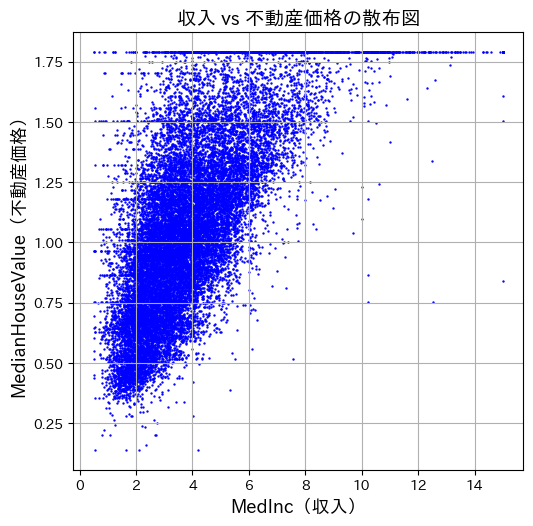

In [35]:
# 散布図表示
# x(収入)とyt(不動産価格)の関係を散布図表示する

plt.figure(figsize=(6,6))
plt.scatter(x[:,1], yt, s=0.5, c='blue')
plt.title('収入 vs 不動産価格の散布図', fontsize=14)
plt.xlabel('MedInc（収入）', fontsize=13)
plt.ylabel('MedianHouseValue（不動産価格）', fontsize=13)
plt.grid(True)
create_pdf()
plt.show()

### 基本関数定義

#### 予測関数

In [36]:
# 予測関数

def predict(x, w):
    """線形回帰モデルによる予測値を計算"""
    return x @ w


#### 損失関数

In [37]:
# 損失関数

def compute_loss(yp, yt):
    """平均二乗誤差 (MSE) に基づく損失関数"""
    return np.mean((yp - yt) ** 2) / 2


### 学習

#### 学習関数

In [44]:
# 学習関数
def train_linear_regression(x, yt, alpha=0.005, iters=5000, his_unit=100):
    """勾配降下法による線形回帰モデルの学習"""
    # M(データ件数)とD(入力データ要素数)の設定
    M, D = x.shape
    # 重みベクトル初期化(全要素1を設定)
    w = np.ones(D)
    # 学習過程記録用
    history = np.zeros((0,2))

    # 繰り返し処理
    for k in range(iters):
        # 予測計算
        yp = predict(x, w)
        # 誤差計算
        yd = yp - yt
        # 勾配(微分)計算
        grad = (x.T @ yd)/M
        # パラメータ修正
        w -=  alpha * grad

        if k % his_unit == 0:
            # 損失計算
            loss = compute_loss(yp, yt)
            # 記録用変数に追記
            history = np.vstack((history, np.array([k, loss])))
            # 結果の画面表示
            print(f"iter={k:5d} | loss={loss:.6f}")
    return w, history

#### 学習

In [45]:
# 学習

# 学習率と繰り返し回数の設定
alpha = 0.005
iters = 5000
his_unit = 100

# 繰り返し処理
w, history = train_linear_regression(x, yt, alpha=alpha, \
            iters=iters, his_unit=his_unit)

iter=    0 | loss=8.685563
iter=  100 | loss=0.039075
iter=  200 | loss=0.038283
iter=  300 | loss=0.037626
iter=  400 | loss=0.037080
iter=  500 | loss=0.036627
iter=  600 | loss=0.036251
iter=  700 | loss=0.035939
iter=  800 | loss=0.035680
iter=  900 | loss=0.035464
iter= 1000 | loss=0.035286
iter= 1100 | loss=0.035137
iter= 1200 | loss=0.035014
iter= 1300 | loss=0.034912
iter= 1400 | loss=0.034827
iter= 1500 | loss=0.034757
iter= 1600 | loss=0.034698
iter= 1700 | loss=0.034649
iter= 1800 | loss=0.034609
iter= 1900 | loss=0.034576
iter= 2000 | loss=0.034548
iter= 2100 | loss=0.034525
iter= 2200 | loss=0.034506
iter= 2300 | loss=0.034490
iter= 2400 | loss=0.034477
iter= 2500 | loss=0.034466
iter= 2600 | loss=0.034456
iter= 2700 | loss=0.034449
iter= 2800 | loss=0.034443
iter= 2900 | loss=0.034437
iter= 3000 | loss=0.034433
iter= 3100 | loss=0.034430
iter= 3200 | loss=0.034427
iter= 3300 | loss=0.034424
iter= 3400 | loss=0.034422
iter= 3500 | loss=0.034420
iter= 3600 | loss=0.034419
i

### 結果分析

#### 損失の確認

In [46]:
# 損失の確認
print(f"損失初期値: {history[0,1]:.06f}")
print(f"損失最終値: {history[-1,1]:.06f}")


損失初期値: 8.685563
損失最終値: 0.034413


#### 学習曲線(損失)

pdf-01-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

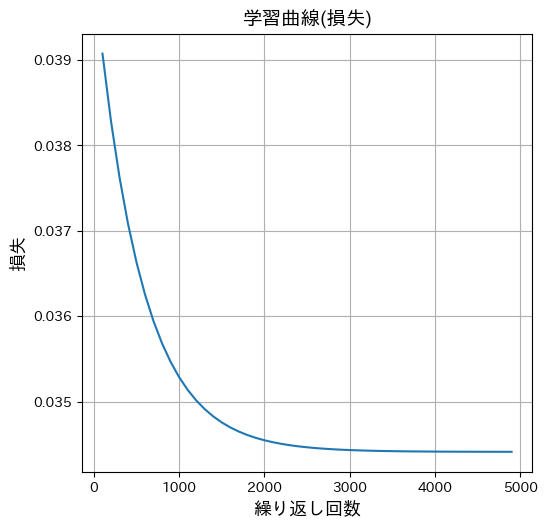

In [42]:
# 学習曲線(損失)
plt.figure(figsize=(6,6))
plt.plot(history[1:,0], history[1:,1])
plt.title('学習曲線(損失)', fontsize=14)
plt.grid()
plt.xlabel('繰り返し回数', fontsize=13)
plt.ylabel('損失', fontsize=13)
create_pdf()
plt.show()

#### 回帰直線の可視化

pdf-01-04.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

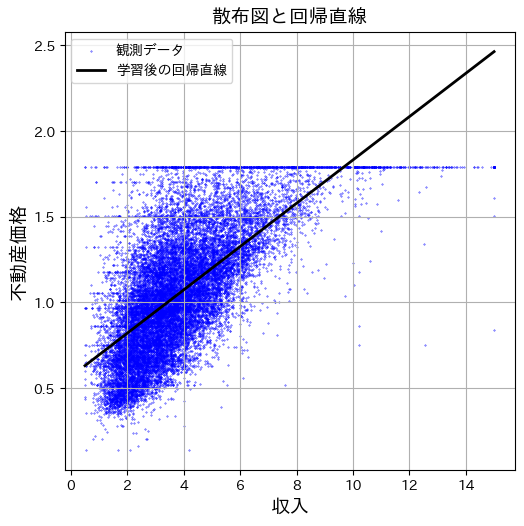

In [43]:
# 回帰直線の可視化

# 回帰直線の座標計算
xall = x[:,1].ravel()
xl = np.array([[1, xall.min()], [1, xall.max()]])
yl = predict(xl, w)

# グラフ描画
plt.figure(figsize=(6,6))
plt.scatter(x[:,1], yt, s=0.1, c='b', label='観測データ')
plt.plot(xl[:,1], yl, c='k', lw=2, label='学習後の回帰直線')
plt.title('散布図と回帰直線', fontsize=14)
plt.xlabel('収入', fontsize=14)
plt.ylabel('不動産価格', fontsize=14)
plt.legend()
plt.grid()
create_pdf()
plt.show()

### 重回帰

#### データ加工(重回帰)

In [47]:
# データ加工(重回帰)

# 特徴量AveRoomsの抽出
x_add = df[['AveRooms']].values

# 特徴量AveRoomsの説明変数xへの追加
x2 = np.hstack((x, x_add))

# 結果確認
print("x2のshape")
print(f"x2.shape: {x2.shape}")
print('x2の先頭5行')
print(x2[:5])

x2のshape
x2.shape: (20640, 3)
x2の先頭5行
[[1.000 8.325 6.984]
 [1.000 8.301 6.238]
 [1.000 7.257 8.288]
 [1.000 5.643 5.817]
 [1.000 3.846 6.282]]


#### 学習(重回帰)

In [21]:
# 学習(重回帰)

# 学習率と繰り返し回数の設定
alpha = 0.005
iters = 5000
his_unit = 100

# 繰り返し処理
w2, history2 = train_linear_regression(x2, yt, alpha=alpha, \
            iters=iters, his_unit=his_unit)

iter=    0 | loss=48.606216
iter=  100 | loss=0.037786
iter=  200 | loss=0.036073
iter=  300 | loss=0.035757
iter=  400 | loss=0.035538
iter=  500 | loss=0.035347
iter=  600 | loss=0.035179
iter=  700 | loss=0.035031
iter=  800 | loss=0.034900
iter=  900 | loss=0.034785
iter= 1000 | loss=0.034684
iter= 1100 | loss=0.034595
iter= 1200 | loss=0.034516
iter= 1300 | loss=0.034447
iter= 1400 | loss=0.034386
iter= 1500 | loss=0.034332
iter= 1600 | loss=0.034285
iter= 1700 | loss=0.034243
iter= 1800 | loss=0.034206
iter= 1900 | loss=0.034174
iter= 2000 | loss=0.034145
iter= 2100 | loss=0.034120
iter= 2200 | loss=0.034098
iter= 2300 | loss=0.034078
iter= 2400 | loss=0.034061
iter= 2500 | loss=0.034046
iter= 2600 | loss=0.034032
iter= 2700 | loss=0.034021
iter= 2800 | loss=0.034010
iter= 2900 | loss=0.034001
iter= 3000 | loss=0.033993
iter= 3100 | loss=0.033986
iter= 3200 | loss=0.033980
iter= 3300 | loss=0.033974
iter= 3400 | loss=0.033969
iter= 3500 | loss=0.033965
iter= 3600 | loss=0.033961


#### 結果分析(重回帰)

損失 初期値 : 48.606216
損失 最終値 : 0.033939
pdf-01-05.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

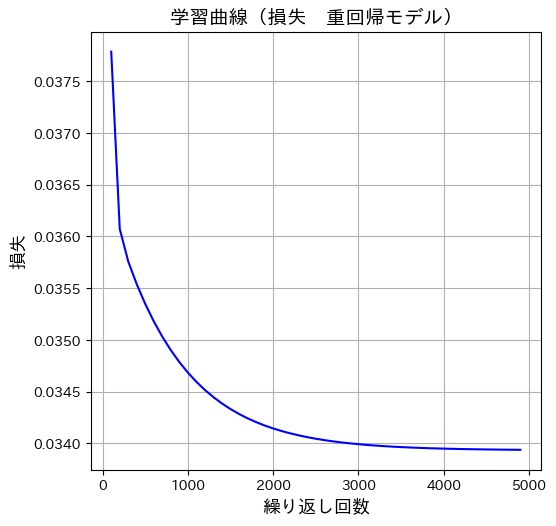

In [48]:
# 結果分析(重回帰)

# 損失の確認
print(f"損失 初期値 : {history2[0,1]:.06f}")
print(f"損失 最終値 : {history2[-1,1]:.06f}")

# 学習曲線(損失　重回帰モデル)
plt.figure(figsize=(6,6))
plt.plot(history[1:,0], history2[1:,1], color='blue')
plt.title('学習曲線（損失　重回帰モデル）', fontsize=14)
plt.xlabel('繰り返し回数', fontsize=13)
plt.ylabel('損失', fontsize=13)
plt.grid(True)
create_pdf()
plt.show()

### バージョン確認

In [23]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
pandas             : 2.2.2
IPython            : 7.34.0
google             : 2.0.3
japanize_matplotlib: 1.1.3
matplotlib_inline  : 0.1.7
numpy              : 2.0.2
sklearn            : 1.6.1
matplotlib         : 3.10.0

